In [1]:
%env CUDA_VISIBLE_DEVICES=5

env: CUDA_VISIBLE_DEVICES=5


In [ ]:
import sys
sys.path.append('..')
from contrib.dmi.data import *
from contrib.dmi.load_data import *
from src.utils import *
from src.models import *

import matplotlib.pyplot as plt
import torch
import itertools

lon_min = -10
lon_max = 30
lat_min = 48
lat_max = 66

datamodule = BaseDataModule_wcoarse_wgeo(input_da=load_data_wcoarse_wgeo_2(path_obs="/DATASET/mbeauchamp/DMI/training_dataset/DMI-L3S_GHRSST-SSTsubskin-night_SST_UHR_NRT-NSEABALTIC.nc",
                                                      path_tgt="/DATASET/mbeauchamp/DMI/4DVarNet_outputs/DMI-L4_GHRSST-SSTfnd-DMI_4DVarNet-NSEABALTIC_2021_dt7_linweights_wcoarse_baltic_ext.nc",     
                                                      path_oi="/DATASET/mbeauchamp/DMI/training_dataset/DMI-L4_GHRSST-SSTfnd-DMI_OI-NSEABALTIC.nc",
                                                      path_coarse="/DATASET/mbeauchamp/DMI/training_dataset/DMI-L3S_GHRSST-SSTsubskin-night_SST_UHR_NRT-NSEABALTIC_w4DVarNet_coarse.nc",
                                                      path_topo="/DATASET/mbeauchamp/DMI/training_dataset/DMI-TOPO_NSEABALTIC.nc",
                                                      path_fgstd="/DATASET/mbeauchamp/DMI/training_dataset/DMI-FGSTD_NSEABALTIC.nc"),
                            domains={'train': {'time': slice('2019-05-01', '2020-12-31',)},
                                     'val': {'time': [ slice('2021-01-01', '2021-01-31',),
                                                       slice('2021-04-01', '2021-04-30',),
                                                       slice('2021-07-01', '2021-07-31',),
                                                       slice('2021-10-01', '2021-10-31',) ]},
                                     'test': {'time': slice('2021-06-01', '2021-06-30',)}},
                            xrds_kw={'patch_dims': {'time': 7, 'lat': 240, 'lon': 240},
                                     'strides': {'time': 1, 'lat': 5, 'lon': 5},
                                     'strides_test': {'time': 1, 'lat': 200, 'lon': 200},
                                     'domain_limits':  dict(lon=slice(lon_min, lon_max,),
                                                            lat=slice(lat_min, lat_max,)),
                                     },
                            dl_kw={'batch_size': 2, 'num_workers': 0},
                            res=0.02,
                            pads=[False,False,True],
                            norm_stats =[-0.015420883207237286,0.4562528584789277])
datamodule.setup()
data_loader = datamodule.train_dataloader()
test_dataloader = datamodule.test_dataloader()

/homes/m19beauc/miniconda3/envs/4dvarnet/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Self attention mechanisms

In [4]:
import torch
from torch import nn
from torch.nn import functional as F
import math

class SelfAttention(nn.Module):
    def __init__(self, n_heads, d_embed, in_proj_bias=True, out_proj_bias=True):
        super().__init__()
        # This combines the Wq, Wk and Wv matrices into one matrix
        self.in_proj = nn.Linear(d_embed, 3 * d_embed, bias=in_proj_bias)
        # This one represents the Wo matrix
        self.out_proj = nn.Linear(d_embed, d_embed, bias=out_proj_bias)
        self.n_heads = n_heads
        self.d_head = d_embed // n_heads

    def forward(self, x, causal_mask=False):
        # x: # (Batch_Size, Seq_Len, Dim)

        # (Batch_Size, Seq_Len, Dim)
        input_shape = x.shape 
        
        # (Batch_Size, Seq_Len, Dim)
        batch_size, sequence_length, d_embed = input_shape 

        # (Batch_Size, Seq_Len, H, Dim / H)
        interim_shape = (batch_size, sequence_length, self.n_heads, self.d_head) 

        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim * 3) -> 3 tensor of shape (Batch_Size, Seq_Len, Dim)
        q, k, v = self.in_proj(x).chunk(3, dim=-1)
        
        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, H, Dim / H) -> (Batch_Size, H, Seq_Len, Dim / H)
        q = q.view(interim_shape).transpose(1, 2)
        k = k.view(interim_shape).transpose(1, 2)
        v = v.view(interim_shape).transpose(1, 2)

        # (Batch_Size, H, Seq_Len, Dim / H) @ (Batch_Size, H, Dim / H, Seq_Len) -> (Batch_Size, H, Seq_Len, Seq_Len)
        weight = q @ k.transpose(-1, -2)
        
        if causal_mask:
            # Mask where the upper triangle (above the principal diagonal) is 1
            mask = torch.ones_like(weight, dtype=torch.bool).triu(1) 
            # Fill the upper triangle with -inf
            weight.masked_fill_(mask, -torch.inf) 
        
        # Divide by d_k (Dim / H). 
        # (Batch_Size, H, Seq_Len, Seq_Len) -> (Batch_Size, H, Seq_Len, Seq_Len)
        weight /= math.sqrt(self.d_head) 
        # (Batch_Size, H, Seq_Len, Seq_Len) -> (Batch_Size, H, Seq_Len, Seq_Len)
        weight = F.softmax(weight, dim=-1) 
        # (Batch_Size, H, Seq_Len, Seq_Len) @ (Batch_Size, H, Seq_Len, Dim / H) -> (Batch_Size, H, Seq_Len, Dim / H)
        output = weight @ v
        # (Batch_Size, H, Seq_Len, Dim / H) -> (Batch_Size, Seq_Len, H, Dim / H)
        output = output.transpose(1, 2) 
        # (Batch_Size, Seq_Len, H, Dim / H) -> (Batch_Size, Seq_Len, Dim)
        output = output.reshape(input_shape) 
        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim)
        output = self.out_proj(output) 
        # (Batch_Size, Seq_Len, Dim)
        return output

class CrossAttention(nn.Module):
    def __init__(self, n_heads, d_embed, d_cross, in_proj_bias=True, out_proj_bias=True):
        super().__init__()
        self.q_proj   = nn.Linear(d_embed, d_embed, bias=in_proj_bias)
        self.k_proj   = nn.Linear(d_cross, d_embed, bias=in_proj_bias)
        self.v_proj   = nn.Linear(d_cross, d_embed, bias=in_proj_bias)
        self.out_proj = nn.Linear(d_embed, d_embed, bias=out_proj_bias)
        self.n_heads = n_heads
        self.d_head = d_embed // n_heads
    
    def forward(self, x, y):
        # x (latent): # (Batch_Size, Seq_Len_Q, Dim_Q)
        # y (context): # (Batch_Size, Seq_Len_KV, Dim_KV) = (Batch_Size, 77, 768)

        input_shape = x.shape
        batch_size, sequence_length, d_embed = input_shape
        # Divide each embedding of Q into multiple heads such that d_heads * n_heads = Dim_Q
        interim_shape = (batch_size, -1, self.n_heads, self.d_head)
        
        # (Batch_Size, Seq_Len_Q, Dim_Q) -> (Batch_Size, Seq_Len_Q, Dim_Q)
        q = self.q_proj(x)
        # (Batch_Size, Seq_Len_KV, Dim_KV) -> (Batch_Size, Seq_Len_KV, Dim_Q)
        k = self.k_proj(y)
        # (Batch_Size, Seq_Len_KV, Dim_KV) -> (Batch_Size, Seq_Len_KV, Dim_Q)
        v = self.v_proj(y)

        # (Batch_Size, Seq_Len_Q, Dim_Q) -> (Batch_Size, Seq_Len_Q, H, Dim_Q / H) -> (Batch_Size, H, Seq_Len_Q, Dim_Q / H)
        q = q.view(interim_shape).transpose(1, 2) 
        # (Batch_Size, Seq_Len_KV, Dim_Q) -> (Batch_Size, Seq_Len_KV, H, Dim_Q / H) -> (Batch_Size, H, Seq_Len_KV, Dim_Q / H)
        k = k.view(interim_shape).transpose(1, 2) 
        # (Batch_Size, Seq_Len_KV, Dim_Q) -> (Batch_Size, Seq_Len_KV, H, Dim_Q / H) -> (Batch_Size, H, Seq_Len_KV, Dim_Q / H)
        v = v.view(interim_shape).transpose(1, 2) 
        
        # (Batch_Size, H, Seq_Len_Q, Dim_Q / H) @ (Batch_Size, H, Dim_Q / H, Seq_Len_KV) -> (Batch_Size, H, Seq_Len_Q, Seq_Len_KV)
        weight = q @ k.transpose(-1, -2)
        # (Batch_Size, H, Seq_Len_Q, Seq_Len_KV)
        weight /= math.sqrt(self.d_head)
        # (Batch_Size, H, Seq_Len_Q, Seq_Len_KV)
        weight = F.softmax(weight, dim=-1)
        # (Batch_Size, H, Seq_Len_Q, Seq_Len_KV) @ (Batch_Size, H, Seq_Len_KV, Dim_Q / H) -> (Batch_Size, H, Seq_Len_Q, Dim_Q / H)
        output = weight @ v
        # (Batch_Size, H, Seq_Len_Q, Dim_Q / H) -> (Batch_Size, Seq_Len_Q, H, Dim_Q / H)
        output = output.transpose(1, 2).contiguous()
        # (Batch_Size, Seq_Len_Q, H, Dim_Q / H) -> (Batch_Size, Seq_Len_Q, Dim_Q)
        output = output.view(input_shape)
        # (Batch_Size, Seq_Len_Q, Dim_Q) -> (Batch_Size, Seq_Len_Q, Dim_Q)
        output = self.out_proj(output)
        # (Batch_Size, Seq_Len_Q, Dim_Q)
        return output

# 2. VAE architectures

In [ ]:
###############################################################################
# BSD 3-Clause License
#
# Copyright (c) 2018, NVIDIA CORPORATION. All rights reserved.
#
# Author & Contact: Guilin Liu (guilinl@nvidia.com)
###############################################################################

import torch
import torch.nn.functional as F
from torch import nn, cuda
from torch.autograd import Variable

class PConv2d(nn.Conv2d):
    def __init__(self, *args, **kwargs):

        # whether the mask is multi-channel or not
        if 'multi_channel' in kwargs:
            self.multi_channel = kwargs['multi_channel']
            kwargs.pop('multi_channel')
        else:
            self.multi_channel = False  

        if 'return_mask' in kwargs:
            self.return_mask = kwargs['return_mask']
            kwargs.pop('return_mask')
        else:
            self.return_mask = False

        super(PConv2d, self).__init__(*args, **kwargs)

        if self.multi_channel:
            self.weight_maskUpdater = torch.ones(self.out_channels, self.in_channels, self.kernel_size[0], self.kernel_size[1])
        else:
            self.weight_maskUpdater = torch.ones(1, 1, self.kernel_size[0], self.kernel_size[1])
            
        self.slide_winsize = self.weight_maskUpdater.shape[1] * self.weight_maskUpdater.shape[2] * self.weight_maskUpdater.shape[3]

        self.last_size = (None, None, None, None)
        self.update_mask = None
        self.mask_ratio = None

    def forward(self, input, mask_in=None):
        assert len(input.shape) == 4
        if mask_in is not None or self.last_size != tuple(input.shape):
            self.last_size = tuple(input.shape)

            with torch.no_grad():
                if self.weight_maskUpdater.type() != input.type():
                    self.weight_maskUpdater = self.weight_maskUpdater.to(input)

                if mask_in is None:
                    # if mask is not provided, create a mask
                    if self.multi_channel:
                        mask = torch.ones(input.data.shape[0], input.data.shape[1], input.data.shape[2], input.data.shape[3]).to(input)
                    else:
                        mask = torch.ones(1, 1, input.data.shape[2], input.data.shape[3]).to(input)
                else:
                    mask = mask_in
                        
                self.update_mask = F.conv2d(mask, self.weight_maskUpdater, bias=None, stride=self.stride, padding=self.padding, dilation=self.dilation, groups=1)

                # for mixed precision training, change 1e-8 to 1e-6
                self.mask_ratio = self.slide_winsize/(self.update_mask + 1e-8)
                # self.mask_ratio = torch.max(self.update_mask)/(self.update_mask + 1e-8)
                self.update_mask = torch.clamp(self.update_mask, 0, 1)
                self.mask_ratio = torch.mul(self.mask_ratio, self.update_mask)


        raw_out = super(PConv2d, self).forward(torch.mul(input, mask) if mask_in is not None else input)

        if self.bias is not None:
            bias_view = self.bias.view(1, self.out_channels, 1, 1)
            output = torch.mul(raw_out - bias_view, self.mask_ratio) + bias_view
            output = torch.mul(output, self.update_mask)
        else:
            output = torch.mul(raw_out, self.mask_ratio)


        if self.return_mask:
            return output, self.update_mask
        else:
            return output

In [5]:
import torch
from torch import nn
from torch.nn import functional as F

class VAE_AttentionBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.groupnorm = nn.GroupNorm(32, channels)
        self.attention = SelfAttention(1, channels)
    
    def forward(self, x, mask):
        # x: (Batch_Size, Features, Height, Width)

        residue = x 

        # (Batch_Size, Features, Height, Width) -> (Batch_Size, Features, Height, Width)
        x = self.groupnorm(x)
        x = torch.cat([x,mask], dim=1)
        
        n, c, h, w = x.shape
        
        # (Batch_Size, Features, Height, Width) -> (Batch_Size, Features, Height * Width)
        x = x.view((n, c, h * w)) 
        # (Batch_Size, Features, Height * Width) -> (Batch_Size, Height * Width, Features). Each pixel becomes a feature of size "Features", the sequence length is "Height * Width".
        x = x.transpose(-1, -2)
        # Perform self-attention WITHOUT mask
        # (Batch_Size, Height * Width, Features) -> (Batch_Size, Height * Width, Features)
        x = self.attention(x)
        # (Batch_Size, Height * Width, Features) -> (Batch_Size, Features, Height * Width)
        x = x.transpose(-1, -2)
        # (Batch_Size, Features, Height * Width) -> (Batch_Size, Features, Height, Width)
        x = x.view((n, c, h, w))
        x, mask = x[:,:(c//2),:,:] , mask
        # (Batch_Size, Features, Height, Width) + (Batch_Size, Features, Height, Width) -> (Batch_Size, Features, Height, Width) 
        x += residue

        # (Batch_Size, Features, Height, Width)
        return x, mask

class VAE_ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.groupnorm_1 = nn.GroupNorm(32, in_channels)
        self.conv_1 = PConv2d(in_channels, out_channels, kernel_size=3, padding=1, return_mask=True)

        self.groupnorm_2 = nn.GroupNorm(32, out_channels)
        self.conv_2 = PConv2d(out_channels, out_channels, kernel_size=3, padding=1, return_mask=True)

        if in_channels == out_channels:
            self.residual_layer = nn.Identity()
        else:
            self.residual_layer = PConv2d(in_channels, out_channels, kernel_size=1, padding=0, return_mask=True)
    
    def forward(self, x, mask):
        # x: (Batch_Size, In_Channels, Height, Width)

        residue = x
                
        # (Batch_Size, In_Channels, Height, Width) -> (Batch_Size, In_Channels, Height, Width)
        x = self.groupnorm_1(x)
        # (Batch_Size, In_Channels, Height, Width) -> (Batch_Size, In_Channels, Height, Width)
        x = F.silu(x)
        # (Batch_Size, In_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        x, mask = self.conv_1(x, mask)
        # (Batch_Size, Out_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        x = self.groupnorm_2(x)
        # (Batch_Size, Out_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        x = F.silu(x)
        # (Batch_Size, Out_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        x, mask = self.conv_2(x, mask)
        # (Batch_Size, Out_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        return x + self.residual_layer(residue, mask)[0], mask

    
class VAE_Encoder(nn.Sequential):
    def __init__(self, in_channels=9, out_channels=28):
        super().__init__(
            # (Batch_Size, Channel, Height, Width) -> (Batch_Size, 128, Height, Width)
            PConv2d(in_channels, 128, kernel_size=3, padding=1, return_mask=True),  
             # (Batch_Size, 128, Height, Width) -> (Batch_Size, 128, Height, Width)
            VAE_ResidualBlock(128, 128),
            # (Batch_Size, 128, Height, Width) -> (Batch_Size, 128, Height, Width)
            VAE_ResidualBlock(128, 128),
            # (Batch_Size, 128, Height, Width) -> (Batch_Size, 128, Height / 2, Width / 2)
            PConv2d(128, 128, kernel_size=3, stride=2, padding=0, return_mask=True),
            # (Batch_Size, 128, Height / 2, Width / 2) -> (Batch_Size, 256, Height / 2, Width / 2)
            VAE_ResidualBlock(128, 256), 
            # (Batch_Size, 256, Height / 2, Width / 2) -> (Batch_Size, 256, Height / 2, Width / 2)
            VAE_ResidualBlock(256, 256), 
            # (Batch_Size, 256, Height / 2, Width / 2) -> (Batch_Size, 256, Height / 4, Width / 4)
            PConv2d(256, 256, kernel_size=3, stride=2, padding=0, return_mask=True), 
            # (Batch_Size, 256, Height / 4, Width / 4) -> (Batch_Size, 512, Height / 4, Width / 4)
            VAE_ResidualBlock(256, 512), 
            # (Batch_Size, 512, Height / 4, Width / 4) -> (Batch_Size, 512, Height / 4, Width / 4)
            VAE_ResidualBlock(512, 512), 
            # (Batch_Size, 512, Height / 4, Width / 4) -> (Batch_Size, 512, Height / 8, Width / 8)
            PConv2d(512, 512, kernel_size=3, stride=2, padding=0, return_mask=True), 
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            VAE_ResidualBlock(512, 512), 
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            VAE_ResidualBlock(512, 512), 
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            VAE_ResidualBlock(512, 512), 
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            VAE_AttentionBlock(512), 
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            VAE_ResidualBlock(512, 512), 
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            nn.GroupNorm(32, 512), 
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            nn.SiLU(), 

            # Because the padding=1, it means the width and height will increase by 2
            # Out_Height = In_Height + Padding_Top + Padding_Bottom
            # Out_Width = In_Width + Padding_Left + Padding_Right
            # Since padding = 1 means Padding_Top = Padding_Bottom = Padding_Left = Padding_Right = 1,
            # Since the Out_Width = In_Width + 2 (same for Out_Height), it will compensate for the Kernel size of 3
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 8, Height / 8, Width / 8). 
            PConv2d(512, out_channels, kernel_size=3, padding=1, return_mask=True), 

            # (Batch_Size, 8, Height / 8, Width / 8) -> (Batch_Size, 8, Height / 8, Width / 8)
            PConv2d(out_channels, out_channels, kernel_size=1, padding=0, return_mask=True), 
        )

    def forward(self, x):
        # x: (Batch_Size, Channel, Height, Width)
        # noise: (Batch_Size, 4, Height / 8, Width / 8)

        mask = torch.where(x==0.)
        
        for module in self:

            if getattr(module, 'stride', None) == (2, 2):  # Padding at downsampling should be asymmetric (see #8)
                # Pad: (Padding_Left, Padding_Right, Padding_Top, Padding_Bottom).
                # Pad with zeros on the right and bottom.
                # (Batch_Size, Channel, Height, Width) -> (Batch_Size, Channel, Height + Padding_Top + Padding_Bottom, Width + Padding_Left + Padding_Right) = (Batch_Size, Channel, Height + 1, Width + 1)
                x = F.pad(x, (0, 1, 0, 1))
                
            if (isinstance(module, nn.GroupNorm) or isinstance(module, nn.SiLU)):
                x = module(x)
            else:
                x, mask = module(x,mask)
                
        # (Batch_Size, 8, Height / 8, Width / 8) -> two tensors of shape (Batch_Size, 4, Height / 8, Width / 8)
        mean, log_variance = torch.chunk(x, 2, dim=1)
        # Clamp the log variance between -30 and 20, so that the variance is between (circa) 1e-14 and 1e8. 
        # (Batch_Size, 4, Height / 8, Width / 8) -> (Batch_Size, 4, Height / 8, Width / 8)
        log_variance = torch.clamp(log_variance, -30, 20)
        # (Batch_Size, 4, Height / 8, Width / 8) -> (Batch_Size, 4, Height / 8, Width / 8)
        variance = log_variance.exp()
        # (Batch_Size, 4, Height / 8, Width / 8) -> (Batch_Size, 4, Height / 8, Width / 8)
        stdev = variance.sqrt()
        
        # reparametrization trick: Transform N(0, 1) -> N(mean, stdev) 
        # (Batch_Size, 4, Height / 8, Width / 8) -> (Batch_Size, 4, Height / 8, Width / 8)
        noise = torch.Tensor(np.random.normal(size=mean.size(), scale=1.0)).to(x.device)
        x = mean + stdev * noise
        
        # Scale by a constant
        # Constant taken from: https://github.com/CompVis/stable-diffusion/blob/21f890f9da3cfbeaba8e2ac3c425ee9e998d5229/configs/stable-diffusion/v1-inference.yaml#L17C1-L17C1
        x *= 0.18215
        
        return x, mean, log_variance

class VAE_Decoder(nn.Sequential):
    def __init__(self,in_channels=14, out_channels=9):
        super().__init__(
            # (Batch_Size, 4, Height / 8, Width / 8) -> (Batch_Size, 4, Height / 8, Width / 8)
            nn.Conv2d(in_channels, 4, kernel_size=1, padding=0),
            # (Batch_Size, 4, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            nn.Conv2d(4, 512, kernel_size=3, padding=1),   
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            VAE_ResidualBlock(512, 512), 
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            VAE_AttentionBlock(512), 
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            VAE_ResidualBlock(512, 512), 
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            VAE_ResidualBlock(512, 512), 
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            VAE_ResidualBlock(512, 512), 
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            VAE_ResidualBlock(512, 512), 
            # Repeats the rows and columns of the data by scale_factor (like when you resize an image by doubling its size).
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 4, Width / 4)
            nn.Upsample(scale_factor=2),
            # (Batch_Size, 512, Height / 4, Width / 4) -> (Batch_Size, 512, Height / 4, Width / 4)
            nn.Conv2d(512, 512, kernel_size=3, padding=1), 
            # (Batch_Size, 512, Height / 4, Width / 4) -> (Batch_Size, 512, Height / 4, Width / 4)
            VAE_ResidualBlock(512, 512), 
            # (Batch_Size, 512, Height / 4, Width / 4) -> (Batch_Size, 512, Height / 4, Width / 4)
            VAE_ResidualBlock(512, 512), 
            # (Batch_Size, 512, Height / 4, Width / 4) -> (Batch_Size, 512, Height / 4, Width / 4)
            VAE_ResidualBlock(512, 512), 
            # (Batch_Size, 512, Height / 4, Width / 4) -> (Batch_Size, 512, Height / 2, Width / 2)
            nn.Upsample(scale_factor=2), 
            # (Batch_Size, 512, Height / 2, Width / 2) -> (Batch_Size, 512, Height / 2, Width / 2)
            nn.Conv2d(512, 512, kernel_size=3, padding=1), 
            # (Batch_Size, 512, Height / 2, Width / 2) -> (Batch_Size, 256, Height / 2, Width / 2)
            VAE_ResidualBlock(512, 256), 
            # (Batch_Size, 256, Height / 2, Width / 2) -> (Batch_Size, 256, Height / 2, Width / 2)
            VAE_ResidualBlock(256, 256), 
            # (Batch_Size, 256, Height / 2, Width / 2) -> (Batch_Size, 256, Height / 2, Width / 2)
            VAE_ResidualBlock(256, 256), 
            # (Batch_Size, 256, Height / 2, Width / 2) -> (Batch_Size, 256, Height, Width)
            nn.Upsample(scale_factor=2), 
            # (Batch_Size, 256, Height, Width) -> (Batch_Size, 256, Height, Width)
            nn.Conv2d(256, 256, kernel_size=3, padding=1), 
            # (Batch_Size, 256, Height, Width) -> (Batch_Size, 128, Height, Width)
            VAE_ResidualBlock(256, 128), 
            # (Batch_Size, 128, Height, Width) -> (Batch_Size, 128, Height, Width)
            VAE_ResidualBlock(128, 128), 
            # (Batch_Size, 128, Height, Width) -> (Batch_Size, 128, Height, Width)
            VAE_ResidualBlock(128, 128), 
            # (Batch_Size, 128, Height, Width) -> (Batch_Size, 128, Height, Width)
            nn.GroupNorm(32, 128), 
            # (Batch_Size, 128, Height, Width) -> (Batch_Size, 128, Height, Width)
            nn.SiLU(), 
            # (Batch_Size, 128, Height, Width) -> (Batch_Size, 3, Height, Width)
            nn.Conv2d(128, out_channels, kernel_size=3, padding=1), 
        )

    def forward(self, x):
        # x: (Batch_Size, 4, Height / 8, Width / 8)
        
        # Remove the scaling added by the Encoder.
        x /= 0.18215

        for module in self:
            x = module(x)

        # (Batch_Size, 3, Height, Width)
        return x

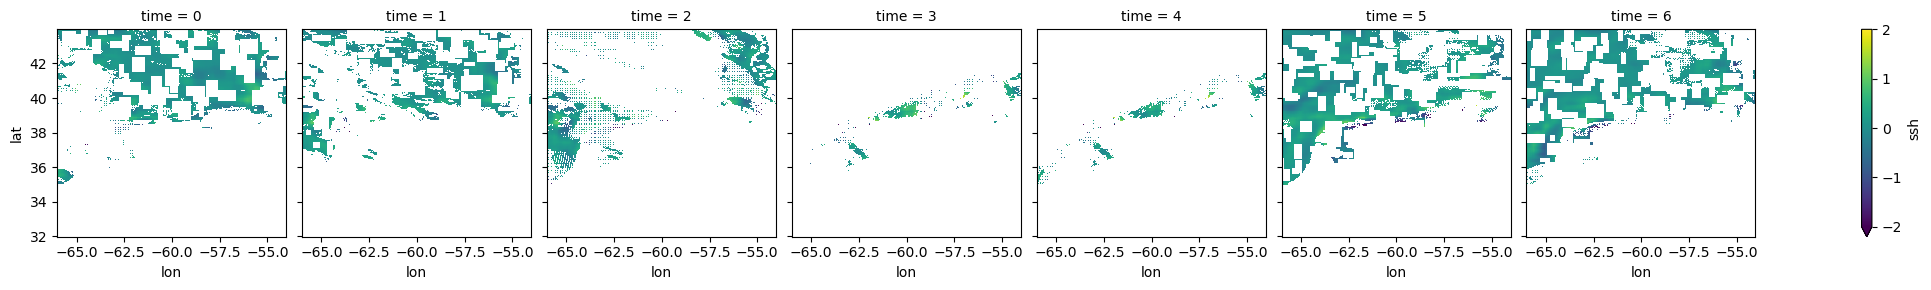

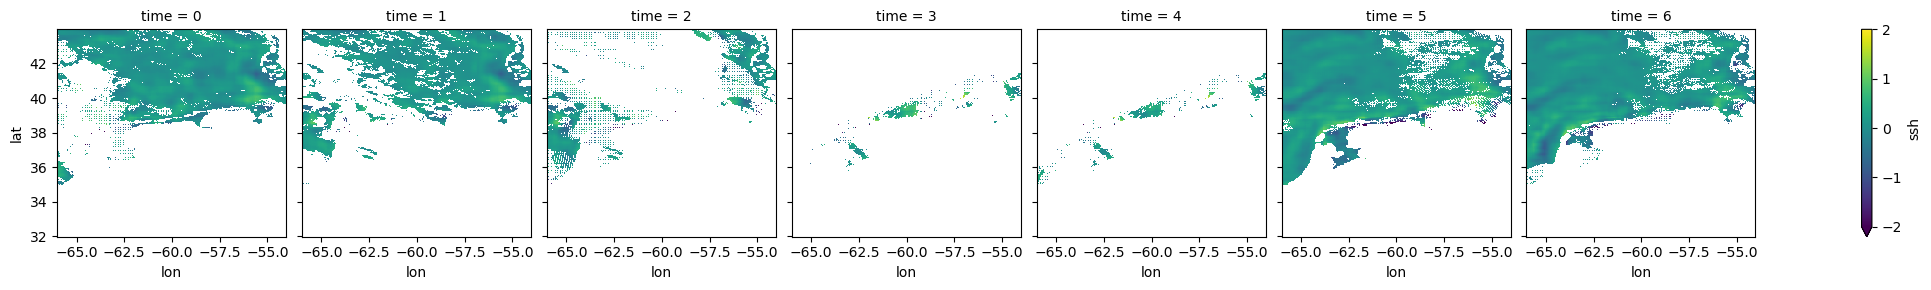

In [20]:
k=20
my_sample = next(itertools.islice(data_loader, k, None))

fig, axs = plt.subplots(2,1)
y = my_sample[0]
xr.Dataset(data_vars={'ssh':(('time','lat','lon'),y[0])},
           coords={'time':np.arange(7),
                   'lon':np.arange(-66, -54, 0.05),
                   'lat':np.arange(32, 44, 0.05)}).ssh.plot(col='time',cmap=cmo.cm.balance,
                                                            col_wrap=7,vmin=-2,vmax=2, ax=axs[0],
                                                            add_colorbar=False)
y = my_sample[1]
xr.Dataset(data_vars={'ssh':(('time','lat','lon'),y[0])},
           coords={'time':np.arange(7),
                   'lon':np.arange(-66, -54, 0.05),
                   'lat':np.arange(32, 44, 0.05)}).ssh.plot(col='time',cmap=cmo.cm.balance,
                                                            col_wrap=7,vmin=-2,vmax=2, ax=axs[1],
                                                            add_colorbar=False)

# Colorbar
cbar_ax = fig.add_axes([0.13, 0.1, 0.77, 0.05])
cbar_ax.tick_params(labelsize=22) 
cm = cmo.cm.balance
vmin=-2
vmax=2
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
sm._A = []
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal', pad=3.0)
cbar.set_label('Sea Surface Temperature anomaly [K]',fontsize=26)

plt.show()

# VAE model

In [7]:
device='cuda'

class VAE(nn.Sequential):
    def __init__(self,in_channels=9, out_channels=28):
        super().__init__()
        self.encoder = VAE_Encoder(in_channels, out_channels).to(device)
        self.decoder = VAE_Decoder(out_channels//2,in_channels).to(device)
        
    def vae_loss(self, x, x_hat, mean, log_var, wKL=.01):
        err = x_hat-x
        mask = torch.isnan(err)
        zeros= torch.zeros(err.size()).to(device)
        reproduction_loss = nn.functional.mse_loss(err[~mask], zeros[~mask], reduction='mean')
        KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
        return reproduction_loss + wKL*KLD, reproduction_loss, KLD
    
    def forward(self, x):
        # encoder
        z, mean, log_var = self.encoder(x)
        # decoder
        x_hat = self.decoder(z)
        return x_hat
        
vae = VAE(in_channels=7, out_channels=50)

# Training

In [15]:
#ckpt = torch.load('ckpt/ckpt_vae_dmi.pth', map_location=device)
#vae.load_state_dict(ckpt)

FileNotFoundError: [Errno 2] No such file or directory: 'ckpt/ckpt_vae_dmi.pth'

In [13]:
#@title Training (double click to expand or collapse)

from IPython.display import clear_output
from torch.optim import Adam
from tqdm.autonotebook import tqdm

n_epochs =  1000#@param {'type':'integer'}
## learning rate
lr = 1e-4 #@param {'type':'number'}

optimizer = Adam(
        [
            {"params": vae.encoder.parameters(), "lr": lr},
            {"params": vae.decoder.parameters(), "lr": lr},
        ],
    )

tqdm_epoch = tqdm(range(n_epochs))
for epoch in tqdm_epoch:
  avg_loss = 0.
  num_items = 0
  for batch in dataloader:
    y = batch[0]
    x = batch[1]
    y = x.nan_to_num().to(device)
    z, mean, log_var = vae.encoder(y)
    x_hat = vae.decoder(z)
    loss_vae, rec, KL = vae.vae_loss(x.to(device), x_hat, mean, log_var, wKL=0.001)
    loss = loss_vae
    #print(rec, KL)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    avg_loss += loss.item() * x.shape[0]
    num_items += x.shape[0]
  # Print the averaged training loss so far.
  tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
  # Update the checkpoint after each epoch of training.
  torch.save(ldm.state_dict(), 'ckpt/ckpt_vae_dmi.pth')

  0%|                                                  | 0/1000 [00:03<?, ?it/s]


KeyboardInterrupt: 

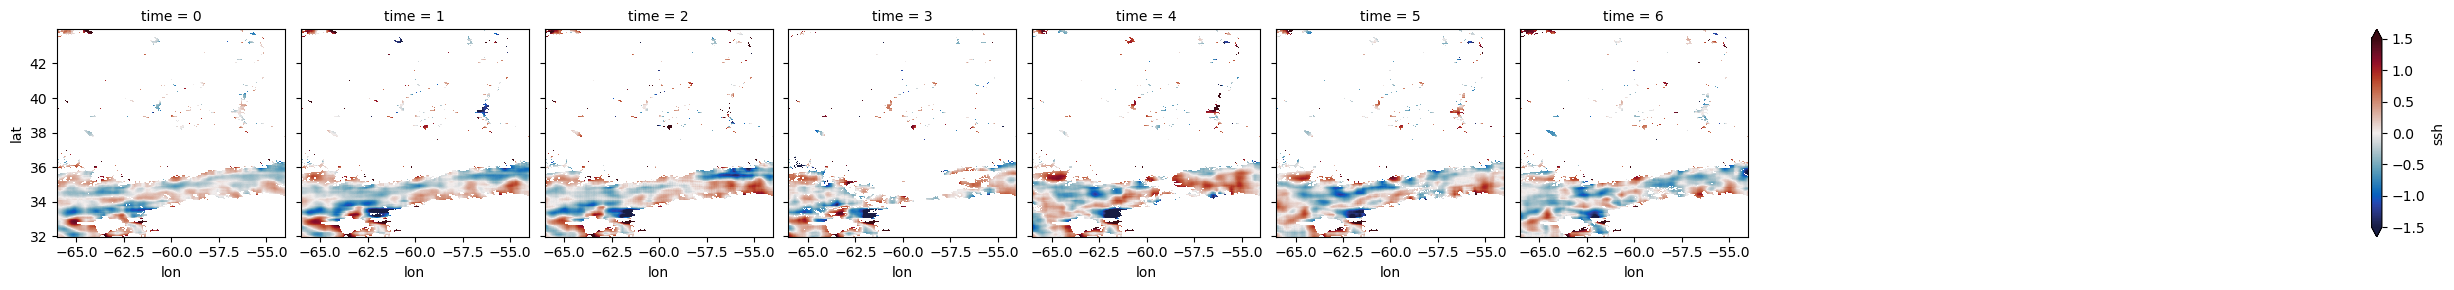

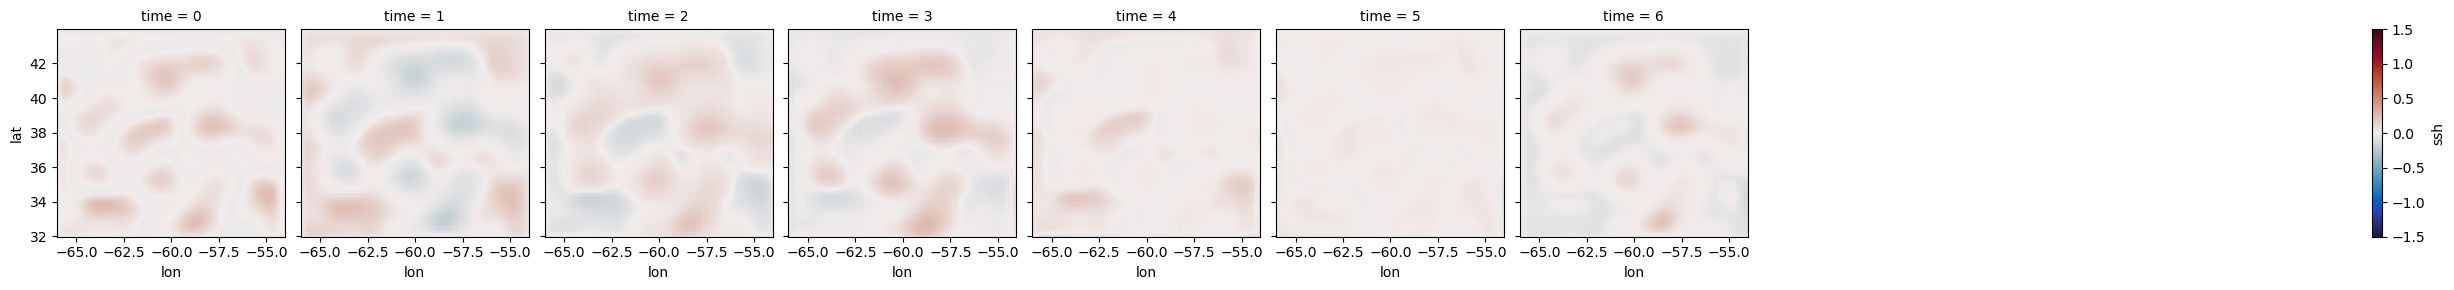

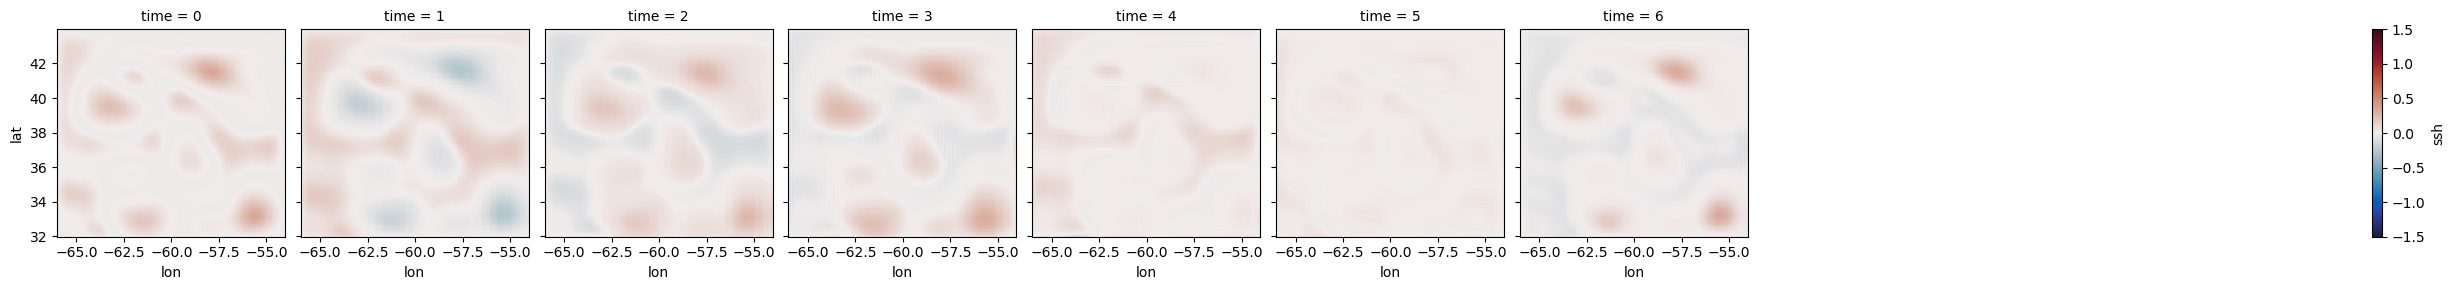

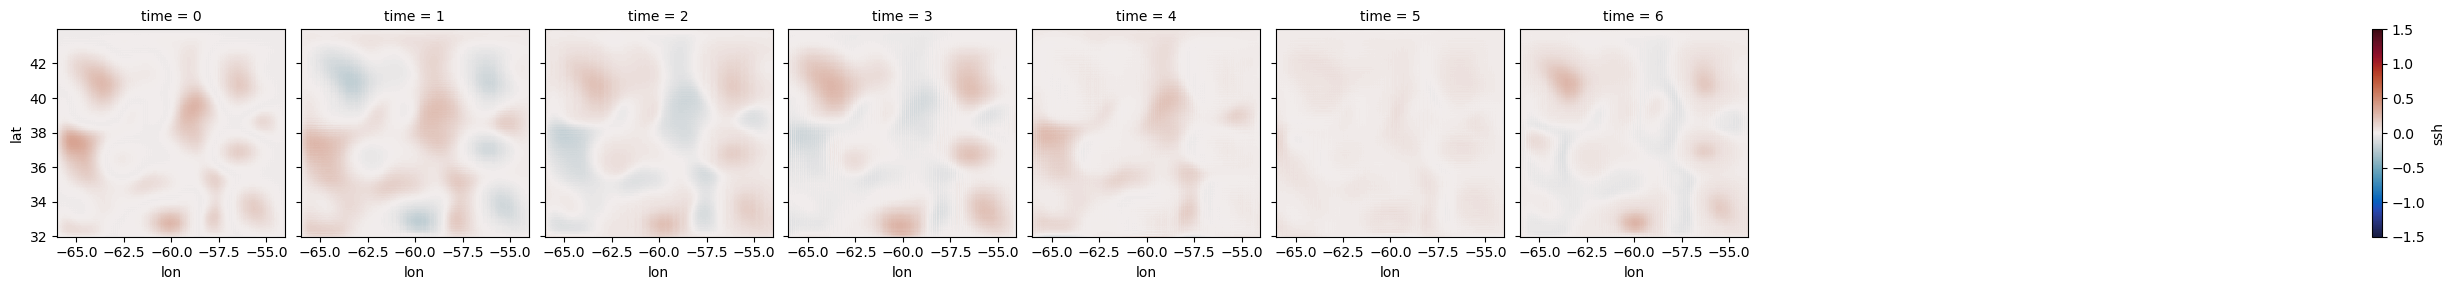

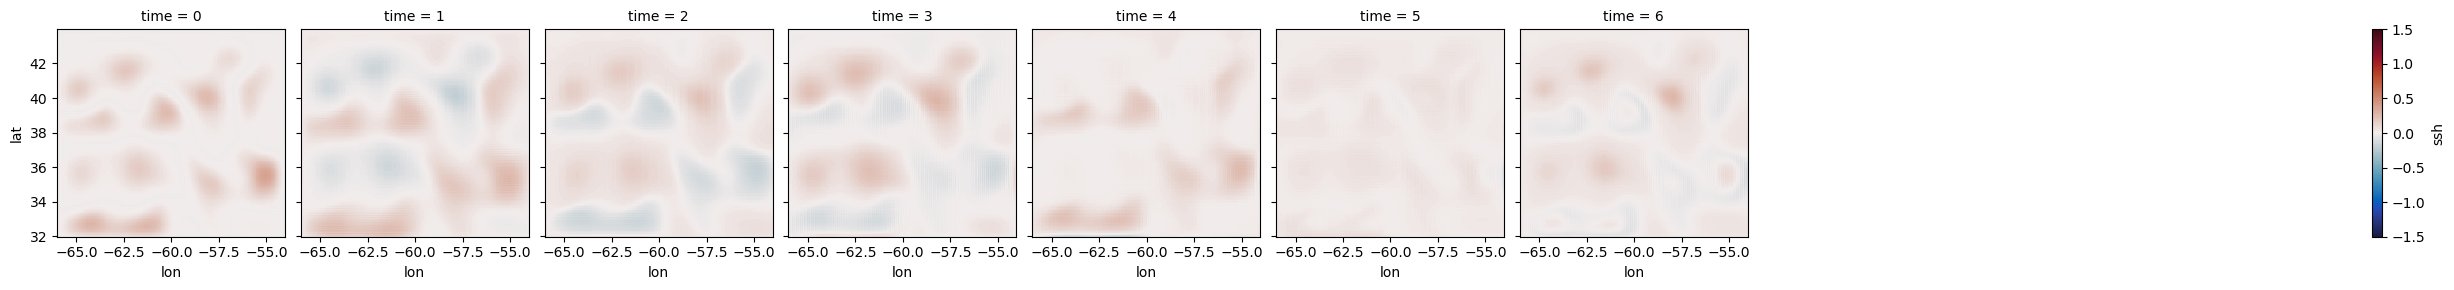

In [14]:
import cmocean as cmo
xr.Dataset(data_vars={'ssh':(('time','lat','lon'),batch[0].detach().cpu()[0])},
           coords={'time':np.arange(7),
                   'lon':np.arange(-66, -54, 0.05),
                   'lat':np.arange(32, 44, 0.05)}).ssh.plot(col='time',col_wrap=9,vmin=-1.5,vmax=1.5,cmap=cmo.cm.balance)
plt.show()

z, mean, log_var = vae.encoder(x)
x_hat = vae.decoder(z)
xr.Dataset(data_vars={'ssh':(('time','lat','lon'),x_hat.detach().cpu()[0])},
           coords={'time':np.arange(7),
                   'lon':np.arange(-66, -54, 0.05),
                   'lat':np.arange(32, 44, 0.05)}).ssh.plot(col='time',col_wrap=9,vmin=-1.5,vmax=1.5,cmap=cmo.cm.balance)
plt.show()

z, mean, log_var = vae.encoder(x)
x_hat = vae.decoder(z)
xr.Dataset(data_vars={'ssh':(('time','lat','lon'),x_hat.detach().cpu()[0])},
           coords={'time':np.arange(7),
                   'lon':np.arange(-66, -54, 0.05),
                   'lat':np.arange(32, 44, 0.05)}).ssh.plot(col='time',col_wrap=9,vmin=-1.5,vmax=1.5,cmap=cmo.cm.balance)
plt.show()

z = torch.Tensor(np.random.normal(size=z.size(), scale=1.0)).to(x.device)
x_hat = vae.decoder(z)
xr.Dataset(data_vars={'ssh':(('time','lat','lon'),x_hat.detach().cpu()[0])},
           coords={'time':np.arange(7),
                   'lon':np.arange(-66, -54, 0.05),
                   'lat':np.arange(32, 44, 0.05)}).ssh.plot(col='time',col_wrap=9,vmin=-1.5,vmax=1.5,cmap=cmo.cm.balance)
plt.show()

z = torch.Tensor(np.random.normal(size=z.size(), scale=1.0)).to(x.device)
x_hat = vae.decoder(z)
xr.Dataset(data_vars={'ssh':(('time','lat','lon'),x_hat.detach().cpu()[0])},
           coords={'time':np.arange(7),
                   'lon':np.arange(-66, -54, 0.05),
                   'lat':np.arange(32, 44, 0.05)}).ssh.plot(col='time',col_wrap=9,vmin=-1.5,vmax=1.5,cmap=cmo.cm.balance)
plt.show()